# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict with training model](#Predict-with-training-model)
    * [Predict with serving model](#Predict-with-serving-model)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# eventual initialization for collab notebooks
if IN_COLAB:
  # we try hard to be re-entrant,
  # that is to be able to rerun this without cloning repository more than once
  COLAB_BRANCH = "master"
  !curl https://raw.githubusercontent.com/openfoodfacts/off-category-classification/$COLAB_BRANCH/lib/colab.py --output /content/colab.py
  !cd /content && python /content/colab.py $COLAB_BRANCH
  %cd /content/off-category-classification/experiments

In [2]:
# codecarbon - start tracking
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(log_level = "WARNING", save_to_api = True, experiment_id = "6d2c8401-afba-42de-9600-6e95bea5fd80")
tracker.start()

[codecarbon ERROR @ 10:07:12] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 10:07:12] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon ERROR @ 10:07:13] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 10:07:13] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/

# Imports

In [3]:
import sys
sys.path.append('../') # append a relative path to the top package to the search path

In [4]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib.dataset import *
from lib.directories import init_cache_dir, init_model_dir
from lib.eval import top_predictions
from lib.io import load_training_model, load_serving_model, save_model_bundle
from lib.plot import plot_training_stat

2022-06-09 10:07:17.090737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 10:07:17.090756: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/alex/docker/off-category-classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [5]:
MODEL_BASE_DIR = pathlib.Path('../model')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value, only affects execution time

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train[:5%]'
VAL_SPLIT = 'train[6%:8%]'
TEST_SPLIT = 'train[8%:10%]'

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `load_dataset('off_categories', ...)` to access the dataset.

In [6]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [7]:
tf.random.set_seed(42)

# Taxonomy information

In [8]:
import networkx as nx

class Taxonomy:

  def __init__(self, graph):
    self.graph = graph

  @classmethod
  def from_data(cls, data):
    graph = nx.DiGraph()    
    nodes = []
    edges = []
    for elem in data:
        nodes.append(elem)
        # we prefer to have child relation, so we put parent first
        edges.extend((parent, elem) for parent in data[elem]['parents'])
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    return cls(graph)

  def ancestors(self, cat):
    return nx.ancestors(self.graph, cat)

  def descendants(self, cat):
    return nx.descendants(self.graph, cat)

  def cats_compat(self, cats):
    """Define the compatible and incompatible categories for a list of categories

    The idea is that we don't want to penalize categories that are found by the model,
    because it goes deeper than the 
    """
    # we have two types of categories, the one that have no children in the set
    # they are leaf
    scats = frozenset(cats)
    leafs = frozenset(c for c in cats if not (frozenset(self.descendants(c)) & scats))
    # and the one that have children in the set
    parents = frozenset(c for c in cats if c not in leafs)
    # A category not in the set is compatible 
    # if it is descendant of one of the leaf
    compatibles = frozenset(descendant for c in leafs for descendant in self.descendants(c))
    # compatibles = frozenset(c for c in self.graph if frozenset(self.ancestors(c)) & leafs)
    return compatibles

  def cats_filter(self, categories_vocab):
    """intersect categories vocabulary with taxonomy known categories"""
    return [c for c in categories_vocab if c in self.graph]

In [9]:
import json
! ls category_taxonomy.json || wget https://github.com/openfoodfacts/robotoff-models/releases/download/keras-category-classifier-xx-2.0/category_taxonomy.json

taxo = Taxonomy.from_data(json.load(open('category_taxonomy.json')))

category_taxonomy.json


## Model inputs

In [10]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [11]:
ds = load_dataset('off_categories', split=TRAIN_SPLIT)

2022-06-09 10:07:18.840082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 10:07:18.840103: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 10:07:18.840125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tignasse): /proc/driver/nvidia/version does not exist
2022-06-09 10:07:18.840426: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = 93_000,
    output_sequence_length = 30)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = 64,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = 64,
    recurrent_dropout = 0.2,
    dropout = 0.0))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

2022-06-09 10:07:19.104028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 3.36 s, sys: 913 ms, total: 4.27 s
Wall time: 1.22 s


21947

In [13]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 3,
    max_tokens = 5_000)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

CPU times: user 4.11 s, sys: 1.35 s, total: 5.47 s
Wall time: 1.07 s


5000

## Model output

In [14]:
%%time

from lib.dataset import filter_empty_labels, get_vocabulary, flat_batch, select_feature

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 10)

# intersect with taxonomy vocab
categories_vocab = taxo.cats_filter(categories_vocab)


# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)



len(categories_vocab)

CPU times: user 3.94 s, sys: 1.29 s, total: 5.23 s
Wall time: 977 ms


1201

In [15]:
def add_compatible_categories(ds: tf.data.Dataset):

    def get_compat(cats):
      cats_list = [c.decode("utf-8") for c in cats.numpy()]
      result = list(taxo.cats_compat(taxo.cats_filter(cats_list)))
      return tf.constant(result, dtype=tf.string)

    def _transform(x, y):
        x["compat"] = tf.py_function(func=get_compat, inp=[y], Tout=tf.string)
        # make shape clear to avoid failing at compile time on next steps
        x["compat"] = tf.reshape(x["compat"], [-1])
        return (x, y)
    # apply to dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
    )

In [16]:
def categories_encode(ds: tf.data.Dataset):
    """encode categories
    
    - as multi-hot for y
    - as a mask for "compat" feature
    """

    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        if "compat" in x:
          # vector where compat categories are 1
          binarized = categories_multihot(x["compat"])
          binarized = binarized[1:]  # drop OOV
          # make it a mask where compatibles are 0, the rest one
          binarized = tf.ones(binarized.shape, dtype=tf.float32) - binarized
          # make a new ds (we can't modify current x)
          x = dict(
            x,
            compat=binarized,
          )
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )


## Model

In [17]:
class MaskingModel(tf.keras.Model):
  """A model that applies a mask taken 
  from features to y_pred before computing loss
  """

  def __init__(self, *args, mask_feature="compat", **kwargs):
    super().__init__(*args, **kwargs)
    self.mask_feature = mask_feature

  def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
    # first mask categories we do not want using the compat feature
    mask = x[self.mask_feature]
    # zeros mask_feature in y_pred, as we know they are not in y_pred
    y_pred *= mask
    return super().compute_loss(x, y, y_pred, sample_weight)

In [18]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = MaskingModel(inputs=[inputs[k] for k in features], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [19]:
model.summary()

Model: "masking_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_name (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 30)           0           product_name[0][0]               
__________________________________________________________________________________________________
ingredients_tags (InputLayer)   [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       1404608     text_vectorization[0][0]         
______________________________________________________________________________________

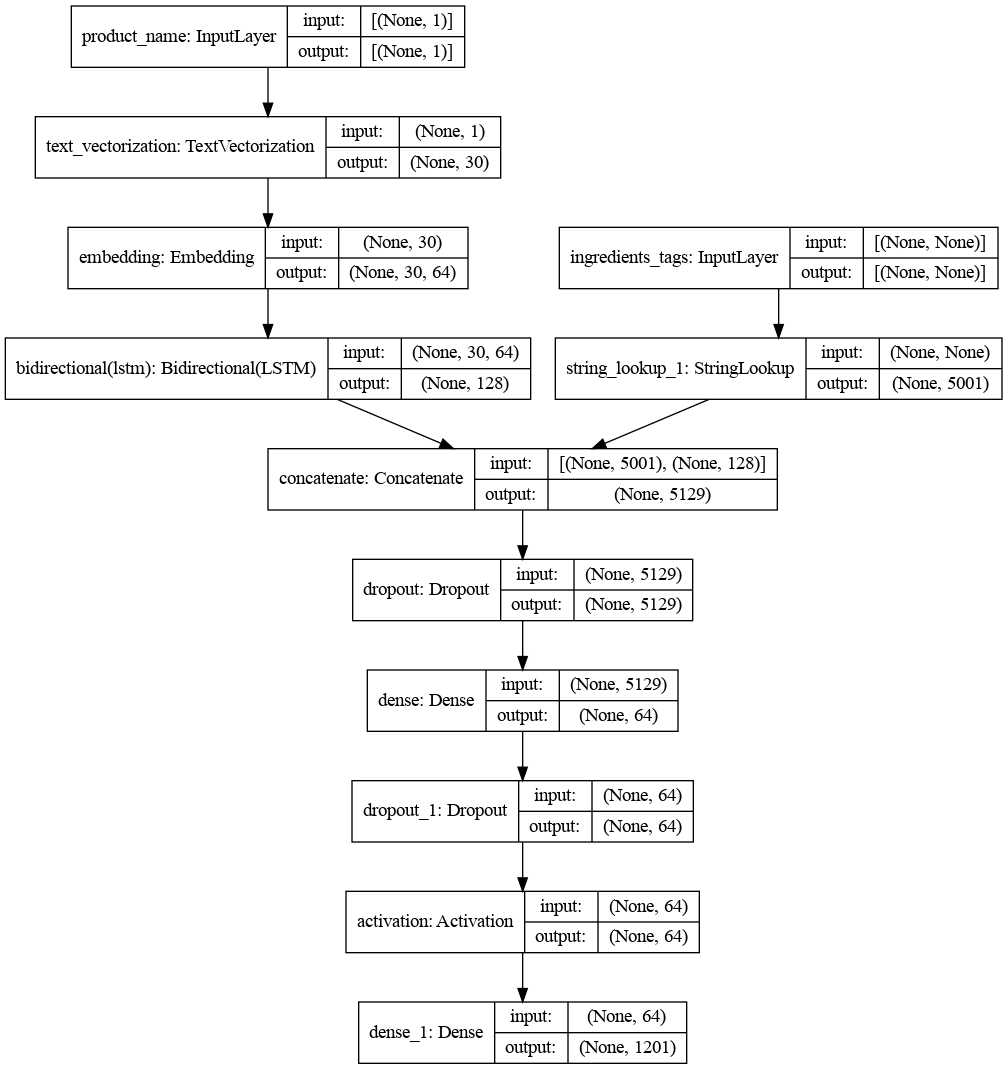

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [21]:
%%time

# Remember to clean obsolete dirs once in a while
MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
CACHE_DIR = init_cache_dir(CACHE_DIR)

batch_size = 128

ds_train = (
    load_dataset('off_categories', split=TRAIN_SPLIT, features=features, as_supervised=True)
    .apply(add_compatible_categories)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset('off_categories', split=VAL_SPLIT, features=features, as_supervised=True)
    .apply(add_compatible_categories)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = 50,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

Model directory: ../model.20220609-100722
Cache directory: ../tensorflow_cache


2022-06-09 10:07:23.024752: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/alex/docker/off-category-classification/.venv/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['compat'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Epoch 1/50
    320/Unknown - 249s 768ms/step - loss: 0.0620 - binary_accuracy: 0.9883 - precision: 0.0059 - recall: 0.0121

2022-06-09 10:11:32.629698: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


321/321 [==============================] - 345s 1s/step - loss: 0.0620 - binary_accuracy: 0.9883 - precision: 0.0059 - recall: 0.0121 - val_loss: 0.0182 - val_binary_accuracy: 0.9961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


2022-06-09 10:13:08.067103: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-09 10:13:10.631525: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.01-0.0182/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.01-0.0182/assets


Epoch 2/50
  2/321 [..............................] - ETA: 22s - loss: 0.0183 - binary_accuracy: 0.9962 - precision: 0.5000 - recall: 0.0026

2022-06-09 10:13:15.318963: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


321/321 [==============================] - 25s 79ms/step - loss: 0.0185 - binary_accuracy: 0.9961 - precision: 0.4234 - recall: 0.0012 - val_loss: 0.0178 - val_binary_accuracy: 0.9961 - val_precision: 0.6847 - val_recall: 0.0020
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.02-0.0178/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.02-0.0178/assets


Epoch 3/50
321/321 [==============================] - 26s 82ms/step - loss: 0.0180 - binary_accuracy: 0.9962 - precision: 0.6678 - recall: 0.0095 - val_loss: 0.0172 - val_binary_accuracy: 0.9962 - val_precision: 0.7022 - val_recall: 0.0178
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.03-0.0172/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.03-0.0172/assets


Epoch 4/50
321/321 [==============================] - 24s 76ms/step - loss: 0.0173 - binary_accuracy: 0.9962 - precision: 0.7163 - recall: 0.0345 - val_loss: 0.0165 - val_binary_accuracy: 0.9963 - val_precision: 0.8079 - val_recall: 0.0452
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.04-0.0165/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.04-0.0165/assets


Epoch 5/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0167 - binary_accuracy: 0.9963 - precision: 0.7244 - recall: 0.0666 - val_loss: 0.0159 - val_binary_accuracy: 0.9963 - val_precision: 0.8228 - val_recall: 0.0732
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.05-0.0159/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.05-0.0159/assets


Epoch 6/50
321/321 [==============================] - 25s 79ms/step - loss: 0.0160 - binary_accuracy: 0.9964 - precision: 0.7203 - recall: 0.1081 - val_loss: 0.0151 - val_binary_accuracy: 0.9965 - val_precision: 0.7794 - val_recall: 0.1222
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.06-0.0151/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.06-0.0151/assets


Epoch 7/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0152 - binary_accuracy: 0.9965 - precision: 0.7245 - recall: 0.1485 - val_loss: 0.0145 - val_binary_accuracy: 0.9966 - val_precision: 0.7832 - val_recall: 0.1585
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.07-0.0145/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.07-0.0145/assets


Epoch 8/50
321/321 [==============================] - 24s 75ms/step - loss: 0.0145 - binary_accuracy: 0.9966 - precision: 0.7389 - recall: 0.1792 - val_loss: 0.0140 - val_binary_accuracy: 0.9966 - val_precision: 0.7902 - val_recall: 0.1829
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.08-0.0140/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.08-0.0140/assets


Epoch 9/50
321/321 [==============================] - 24s 75ms/step - loss: 0.0139 - binary_accuracy: 0.9967 - precision: 0.7501 - recall: 0.2062 - val_loss: 0.0135 - val_binary_accuracy: 0.9967 - val_precision: 0.7968 - val_recall: 0.2015
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.09-0.0135/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.09-0.0135/assets


Epoch 10/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0133 - binary_accuracy: 0.9967 - precision: 0.7572 - recall: 0.2279 - val_loss: 0.0129 - val_binary_accuracy: 0.9968 - val_precision: 0.8021 - val_recall: 0.2213
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.10-0.0129/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.10-0.0129/assets


Epoch 11/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0126 - binary_accuracy: 0.9969 - precision: 0.7815 - recall: 0.2594 - val_loss: 0.0122 - val_binary_accuracy: 0.9969 - val_precision: 0.8334 - val_recall: 0.2574
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.11-0.0122/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.11-0.0122/assets


Epoch 12/50
321/321 [==============================] - 24s 76ms/step - loss: 0.0117 - binary_accuracy: 0.9970 - precision: 0.8039 - recall: 0.3046 - val_loss: 0.0115 - val_binary_accuracy: 0.9970 - val_precision: 0.8477 - val_recall: 0.2900
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.12-0.0115/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.12-0.0115/assets


Epoch 13/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0108 - binary_accuracy: 0.9972 - precision: 0.8149 - recall: 0.3471 - val_loss: 0.0110 - val_binary_accuracy: 0.9972 - val_precision: 0.8470 - val_recall: 0.3308
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.13-0.0110/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.13-0.0110/assets


Epoch 14/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0101 - binary_accuracy: 0.9973 - precision: 0.8264 - recall: 0.3889 - val_loss: 0.0105 - val_binary_accuracy: 0.9973 - val_precision: 0.8533 - val_recall: 0.3580
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.14-0.0105/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.14-0.0105/assets


Epoch 15/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0094 - binary_accuracy: 0.9974 - precision: 0.8342 - recall: 0.4217 - val_loss: 0.0102 - val_binary_accuracy: 0.9974 - val_precision: 0.8508 - val_recall: 0.3866
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.15-0.0102/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.15-0.0102/assets


Epoch 16/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0089 - binary_accuracy: 0.9975 - precision: 0.8386 - recall: 0.4504 - val_loss: 0.0099 - val_binary_accuracy: 0.9974 - val_precision: 0.8457 - val_recall: 0.4133
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.16-0.0099/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.16-0.0099/assets


Epoch 17/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0084 - binary_accuracy: 0.9976 - precision: 0.8453 - recall: 0.4753 - val_loss: 0.0096 - val_binary_accuracy: 0.9975 - val_precision: 0.8442 - val_recall: 0.4342
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.17-0.0096/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.17-0.0096/assets


Epoch 18/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0080 - binary_accuracy: 0.9977 - precision: 0.8460 - recall: 0.4984 - val_loss: 0.0095 - val_binary_accuracy: 0.9976 - val_precision: 0.8460 - val_recall: 0.4509
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.18-0.0095/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.18-0.0095/assets


Epoch 19/50
321/321 [==============================] - 24s 74ms/step - loss: 0.0076 - binary_accuracy: 0.9978 - precision: 0.8508 - recall: 0.5207 - val_loss: 0.0094 - val_binary_accuracy: 0.9976 - val_precision: 0.8405 - val_recall: 0.4646
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.19-0.0094/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.19-0.0094/assets


Epoch 20/50
321/321 [==============================] - 24s 76ms/step - loss: 0.0073 - binary_accuracy: 0.9979 - precision: 0.8551 - recall: 0.5417 - val_loss: 0.0092 - val_binary_accuracy: 0.9976 - val_precision: 0.8478 - val_recall: 0.4766
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.20-0.0092/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.20-0.0092/assets


Epoch 21/50
321/321 [==============================] - 25s 79ms/step - loss: 0.0069 - binary_accuracy: 0.9979 - precision: 0.8579 - recall: 0.5607 - val_loss: 0.0090 - val_binary_accuracy: 0.9977 - val_precision: 0.8465 - val_recall: 0.4916
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.21-0.0090/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.21-0.0090/assets


Epoch 22/50
321/321 [==============================] - 26s 79ms/step - loss: 0.0066 - binary_accuracy: 0.9980 - precision: 0.8602 - recall: 0.5791 - val_loss: 0.0089 - val_binary_accuracy: 0.9977 - val_precision: 0.8374 - val_recall: 0.5115
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.22-0.0089/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.22-0.0089/assets


Epoch 23/50
321/321 [==============================] - 26s 80ms/step - loss: 0.0064 - binary_accuracy: 0.9981 - precision: 0.8628 - recall: 0.5963 - val_loss: 0.0089 - val_binary_accuracy: 0.9978 - val_precision: 0.8369 - val_recall: 0.5274
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.23-0.0089/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.23-0.0089/assets


Epoch 24/50
321/321 [==============================] - 24s 75ms/step - loss: 0.0061 - binary_accuracy: 0.9981 - precision: 0.8640 - recall: 0.6129 - val_loss: 0.0088 - val_binary_accuracy: 0.9978 - val_precision: 0.8355 - val_recall: 0.5402
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.24-0.0088/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.24-0.0088/assets


Epoch 25/50
321/321 [==============================] - 24s 76ms/step - loss: 0.0059 - binary_accuracy: 0.9982 - precision: 0.8678 - recall: 0.6275 - val_loss: 0.0087 - val_binary_accuracy: 0.9978 - val_precision: 0.8314 - val_recall: 0.5509
INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.25-0.0087/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/weights.25-0.0087/assets


Epoch 26/50
321/321 [==============================] - 25s 77ms/step - loss: 0.0057 - binary_accuracy: 0.9982 - precision: 0.8693 - recall: 0.6407 - val_loss: 0.0088 - val_binary_accuracy: 0.9978 - val_precision: 0.8327 - val_recall: 0.5543
Epoch 27/50
321/321 [==============================] - 25s 79ms/step - loss: 0.0055 - binary_accuracy: 0.9983 - precision: 0.8708 - recall: 0.6513 - val_loss: 0.0087 - val_binary_accuracy: 0.9979 - val_precision: 0.8324 - val_recall: 0.5609
Epoch 28/50
321/321 [==============================] - 24s 76ms/step - loss: 0.0053 - binary_accuracy: 0.9983 - precision: 0.8730 - recall: 0.6616 - val_loss: 0.0088 - val_binary_accuracy: 0.9979 - val_precision: 0.8354 - val_recall: 0.5642
Epoch 29/50
321/321 [==============================] - 26s 82ms/step - loss: 0.0052 - binary_accuracy: 0.9984 - precision: 0.8758 - recall: 0.6737 - val_loss: 0.0088 - val_binary_accuracy: 0.9979 - val_precision: 0.8377 - val_recall: 0.5676
CPU times: user 1h 8min 41s, sys: 4m

## Save model and resources

In [22]:
save_model_bundle(MODEL_DIR, model, categories_vocab)

INFO:tensorflow:Assets written to: ../model.20220609-100722/training_model/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/training_model/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/serving_model/assets


INFO:tensorflow:Assets written to: ../model.20220609-100722/serving_model/assets


## Training stats

In [23]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.988261,0.062008,0.005882,0.012109,0.996119,0.018187,0.000000,0.000000
1,1,0.996130,0.018488,0.423440,0.001177,0.996123,0.017760,0.684685,0.001985
2,2,0.996150,0.017965,0.667774,0.009504,0.996158,0.017160,0.702215,0.017799
3,3,0.996212,0.017276,0.716294,0.034526,0.996252,0.016478,0.807935,0.045209
4,4,0.996291,0.016651,0.724360,0.066641,0.996342,0.015850,0.822796,0.073247
5,5,0.996388,0.015962,0.720270,0.108123,0.996458,0.015144,0.779435,0.122152
6,6,0.996488,0.015244,0.724468,0.148507,0.996563,0.014533,0.783175,0.158533
7,7,0.996580,0.014546,0.738853,0.179240,0.996640,0.013981,0.790160,0.182875
8,8,0.996663,0.013857,0.750105,0.206249,0.996701,0.013459,0.796809,0.201510
9,9,0.996731,0.013272,0.757194,0.227940,0.996766,0.012947,0.802073,0.221307


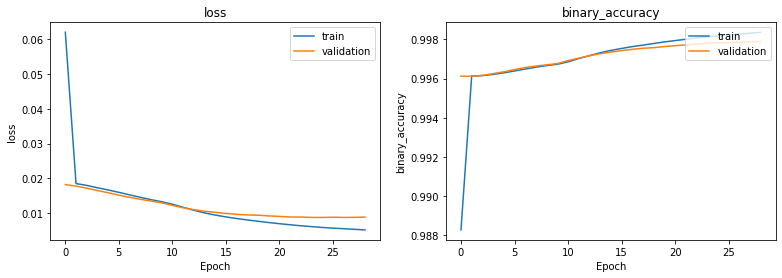

In [24]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

plot_training_stat(stats, 'loss', ax1)
plot_training_stat(stats, 'binary_accuracy', ax2)

# Test model

In [25]:
training_model = load_training_model(MODEL_DIR)
serving_model = load_serving_model(MODEL_DIR)

In [26]:
ds_test = load_dataset('off_categories', split=TEST_SPLIT)

## Predict with training model

In [27]:
%%time

training_pred_test = training_model.predict(ds_test.padded_batch(128))

print(training_pred_test.shape)
training_pred_test

/home/alex/docker/off-category-classification/.venv/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


(17152, 1201)
CPU times: user 7.05 s, sys: 721 ms, total: 7.77 s
Wall time: 2.13 s


array([[7.56065130e-01, 6.95605278e-01, 6.39450550e-03, ...,
        2.48295637e-05, 2.75597811e-01, 7.90536404e-04],
       [1.87312040e-07, 2.00313099e-08, 9.70547438e-01, ...,
        1.07684850e-09, 3.33820254e-12, 3.63423936e-07],
       [7.78834999e-01, 8.39387357e-01, 1.74510479e-02, ...,
        1.40361581e-05, 9.49663263e-06, 4.14192677e-04],
       ...,
       [6.13453627e-01, 6.32865906e-01, 5.71286082e-02, ...,
        5.91233075e-02, 9.31432247e-02, 5.39991260e-02],
       [1.01649165e-02, 5.85269928e-03, 6.26027584e-04, ...,
        2.48351615e-08, 1.20069701e-04, 8.54031654e-08],
       [2.32073665e-03, 5.44816256e-04, 2.72466004e-01, ...,
        7.23749399e-04, 8.23007383e-07, 3.85403073e-05]], dtype=float32)

## Predict with serving model

In [28]:
%%time

serving_pred_test = serving_model.predict(ds_test.padded_batch(128))

serving_pred_test

CPU times: user 9.13 s, sys: 651 ms, total: 9.79 s
Wall time: 2.57 s


(array([[0.75606513, 0.7490587 , 0.700078  , ..., 0.08164254, 0.08117294,
         0.08030871],
        [0.98467934, 0.97054744, 0.9174305 , ..., 0.00139612, 0.0013538 ,
         0.00110024],
        [0.83938736, 0.778835  , 0.619499  , ..., 0.01363865, 0.01304293,
         0.01280984],
        ...,
        [0.6328659 , 0.6134536 , 0.49289724, ..., 0.2693065 , 0.26644152,
         0.26588106],
        [0.9661112 , 0.8412583 , 0.22926542, ..., 0.00188026, 0.00179434,
         0.00168979],
        [0.31938526, 0.3026191 , 0.2856507 , ..., 0.02002802, 0.01874837,
         0.01870233]], dtype=float32),
 array([[b'en:plant-based-foods-and-beverages',
         b'en:fruits-and-vegetables-based-foods', b'en:groceries', ...,
         b'en:vegetable-based-beverages', b'en:vanilla',
         b'en:dehydrated-broths'],
        [b'en:sweet-snacks', b'en:snacks', b'en:confectioneries', ...,
         b'en:honey-candies', b'en:christmas-sweets', b'en:waffles'],
        [b'en:plant-based-foods', b'en:pl

In [29]:
%%time

top_predictions(ds_test, serving_pred_test, 4)

CPU times: user 6.88 s, sys: 741 ms, total: 7.63 s
Wall time: 5.11 s


,code,product_name,0,1,2,3
0,13251212512000081095,Ciboulette Botte 20g,en:plant-based-foods-and-beverages: 75.61%,en:fruits-and-vegetables-based-foods: 74.91%,en:groceries: 70.01%,en:plant-based-foods: 69.56%
1,0688569000565,"Hollow milk chocolate bunny, milk chocolate",en:sweet-snacks: 98.47%,en:snacks: 97.05%,en:confectioneries: 91.74%,en:cocoa-and-its-products: 71.21%
2,3700442602509,Boule aux graines tranchee,en:plant-based-foods: 83.94%,en:plant-based-foods-and-beverages: 77.88%,en:cereals-and-potatoes: 61.95%,en:breads: 54.34%
3,10263426,Turrón imperial con almendras Hacendado 0% sin...,en:snacks: 98.21%,en:sweet-snacks: 98.18%,en:turron: 93.78%,en:christmas-sweets: 93.12%
4,8431876265798,Pimienta negra molida,en:groceries: 73.76%,en:plant-based-foods-and-beverages: 67.14%,en:plant-based-foods: 66.66%,en:condiments: 63.83%
...,...,...,...,...,...,...
17147,5054269266207,White Bread,en:plant-based-foods-and-beverages: 96.68%,en:plant-based-foods: 94.59%,en:breads: 93.98%,en:cereals-and-potatoes: 80.08%
17148,5601029000085,Sardines à l'huile picante,en:seafood: 85.81%,en:fishes: 84.76%,en:canned-fishes: 56.04%,en:canned-foods: 54.71%
17149,3760002456041,Velouté d'asperges,en:plant-based-foods: 63.29%,en:plant-based-foods-and-beverages: 61.35%,en:meals: 49.29%,en:soups: 42.25%
17150,0052100063850,Vegetable dip seasoning mix,en:groceries: 96.61%,en:sauces: 84.13%,en:condiments: 22.93%,en:broths: 18.7%


In [30]:
# codecarbon - stop tracking
tracker.stop()

6.175909715363913e-06